# 🌊 **Analyzing the North Atlantic Ocean by Latitude**

This notebook analyzes chlorophyll-a levels within the **North Atlantic Ocean** by latitude regions. We will use global latitude bands to divide the ocean into horizontal slices (e.g., 30°N–40°N), then calculate daily chlorophyll-a concentration trends within each slice.

The workflow includes:
- Loading the **GOaS ocean boundaries** and **latitude band** datasets.
- Clipping the **North Atlantic** region by each latitude band.
- Extracting **daily chlorophyll values** per band from a NetCDF raster.
- Exporting a time series of chlorophyll means and generating plots.

## 📑 Table of Contents
- [🧰 1. Import Required Libraries](#1-import-required-libraries)  
- [🌊 2. Load Ocean Vector (GOaS)](#2-load-ocean-vector-goas)  
- [🗺️ 3. Load Latitude Bands](#3-load-latitude-bands)  
- [✂️ 4. Clip Ocean by Latitude](#4-clip-ocean-by-latitude)  
- [📈 5. Extract Chlorophyll Data](#5-extract-chlorophyll-data)  
- [📊 6. Visualize Time Series](#6-visualize-time-series)
- [🧭 7. Next Steps](#7-next-steps)


## 🧰 **1. Import Required Libraries**

- **Geospatial libraries**  
  For working with map data like polygons and raster files:  
  - `geopandas` loads and manipulates vector data (e.g., shapefiles, GeoJSON).  
  - `shapely` helps define and clean up geometric shapes.  
  - `rasterio` and `rioxarray` let us read and clip NetCDF raster files (like chlorophyll data).  

- **Data handling and computation**  
  For loading, cleaning, and processing data efficiently:  
  - `pandas` handles tabular data.  
  - `numpy`, `xarray`, and `dask` allow large, multi-dimensional data processing in chunks.  

- **Plotting libraries**  
  To visualize chlorophyll concentrations and trends:  
  - `matplotlib.pyplot` draws plots and maps.  
  - `matplotlib.dates` formats date-based x-axes.  
  - `matplotlib.cm` provides access to color palettes.  

- **Utilities**  
  For smooth workflows and progress tracking:  
  - `tqdm` shows progress bars
  - `pathlib` handles file paths across systems.  
  - `re` helps clean up and format text (like band labels).
  - `loguru` displays clean and colorful logging messages (e.g., 🎉 success, 🚩 error).

In [1]:
# --- Geospatial libraries ---
import geopandas as gpd  # Geographic vector data (GeoDataFrames)
from shapely.geometry import Polygon  # Creating polygon geometries
import rasterio  # Raster file I/O and metadata
import rasterio.mask  # Masking raster data with geometries
import rioxarray as rxr  # Geospatial extension for xarray (CRS-aware raster I/O)

# --- Data handling and computation ---
import pandas as pd  # Tabular data manipulation (DataFrames)
import numpy as np  # Numerical operations
import xarray as xr  # Multi-dimensional labeled arrays (NetCDF, climate, satellite)

# --- Plotting libraries ---
import matplotlib.pyplot as plt  # Core plotting API
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator, ConciseDateFormatter  # Date-based x-axis formatting
from matplotlib import colormaps  # Access to colormaps for styling plots

# --- Utilities ---
from pathlib import Path  # Object-oriented filesystem paths
import re  # Regular expressions for string parsing and pattern matching
from loguru import logger  # Simple, colorful logging
import sys  # For configuring logging output
from tqdm.notebook import tqdm # Progress bars

# Set up the logger to show clean messages (colored text, no background)
from helpers import configure_logger
configure_logger()

# Check that everything was imported successfully
logger.success("🎉 Libraries successfully imported.")

18:52:06 | SUCCESS | 🎉 Libraries successfully imported.


## 🌊 **2. Load Ocean Vector (GOaS)**

Before proceeding, please download the **Global Oceans and Seas (GOaS)** dataset from the following link:  
   [Download GOaS_v1_20211214_gpkg.zip](https://www.marineregions.org/download_file.php?name=GOaS_v1_20211214_gpkg.zip)

   Once downloaded, **extract** the ZIP file and point to the `.gpkg` file in the cell below.

In [2]:
try:
    # Replace with the path to your downloaded GOaS dataset
    goas_vector = gpd.read_file("/Users/chiara/personal_projects/250226_Plankton/GOaS_v1_20211214_gpkg/goas_v01.gpkg")
    logger.success("🎉 GOaS dataset successfully loaded into GeoDataFrame.")
except Exception as e:
    logger.error(f"🚩 Failed to load GOaS dataset: {e}. Did you download the file manually yet?")

18:52:34 | SUCCESS | 🎉 GOaS dataset successfully loaded into GeoDataFrame.


### 2.1: Filter Ocean Vector
In this step, we apply a **filter** to the `goas_vector` **GeoDataFrame** to select features that match the **"North Atlantic Ocean"** in the `"name"` column.

- **Setting the Filter**: We define the `filter_name` variable as `"North Atlantic Ocean"`, which will be used to filter the `goas_vector` dataset.
  
- **Filtering**: We use `str.contains()` with the filter string to **select** only those rows where the `"name"` column contains the filter value, ensuring case-insensitivity and excluding `NaN` values.

This ensures that only relevant features (those matching "North Atlantic Ocean") are retained for further processing.


In [3]:
try:
    # Set the filter for "North Atlantic Ocean"
    filter_name = "North Atlantic Ocean"

    logger.info(f"Filtering GOaS vector for 'name' matching '{filter_name}'")
    goas_vector = goas_vector[goas_vector["name"].str.contains(filter_name, case=False, na=False)]

    if goas_vector.empty:
        logger.warning(f"⚠️ No features found matching 'name' with '{filter_name}'. Exiting.")
        raise ValueError(f"No features found for {filter_name}.")
    else:
        logger.success(f"🎉 Successfully filtered GOaS vector for 'name' matching '{filter_name}'.")

except Exception as filter_error:
    logger.error(f"🚩 Filtering error: {filter_error}")
    raise filter_error

18:52:35 | INFO | Filtering GOaS vector for 'name' matching 'North Atlantic Ocean'
18:52:35 | SUCCESS | 🎉 Successfully filtered GOaS vector for 'name' matching 'North Atlantic Ocean'.


## 🗺️ **3. Load Latitude Bands**

Next, we load the **latitude bands** that we created in "[01_create_latitude_blocks](01_create_latitude_blocks.ipynb)" to clip the ocean vector. These latitude bands will help us analyze one section of the ocean at a time, as different latitudes experience phytoplankton blooms at different times.

In [4]:
try:
    # Replace with the path to the latitude bands GeoJSON file
    clip_vector = gpd.read_file(Path.cwd()/"data/latitude_bands_global.geojson")
    
    logger.success("🎉 Latitude bands successfully loaded into GeoDataFrame.")
except Exception as e:
    logger.error(f"🚩 Failed to load latitude bands: {e}")

18:52:37 | SUCCESS | 🎉 Latitude bands successfully loaded into GeoDataFrame.


## ✂️ **4. Clip Ocean by Latitude**

This step performs the clipping of the **GOaS vector** by each latitude band. For each latitude band:

- We clean the **band label** to make it a valid filename by removing special characters and replacing spaces with underscores.
- We use **GeoPandas’ `clip` function** to clip the ocean data based on the latitude band’s geometry.

In [5]:
try:
    all_clipped_geometries = []  # List to store clipped geometries
    band_labels = []  # List to store corresponding band labels
    
    # Iterate through each latitude band and clip
    for _, row in clip_vector.iterrows():
        clip_geom = row.geometry
        band_label = row["Latitude_Range"]

        # Clean the band label: Replace spaces with "_", slashes with "-", and remove degree signs
        band_label = re.sub(r"[°]", "", band_label)  # Remove degree signs
        band_label = band_label.replace(" ", "_").replace("/", "-")

        logger.info(f"Clipping for latitude range {band_label}...")

        # Use GeoPandas `clip` function to clip the GOaS vector by the latitude band geometry
        clipped_gdf = gpd.clip(goas_vector, clip_geom)

        # Add to the list if not empty
        if not clipped_gdf.empty:
            all_clipped_geometries.append(clipped_gdf)  # Collect clipped data
            band_labels.append(band_label)  # Collect the corresponding band label
            logger.success(f"🎉 Clipped data for {band_label} added.")
        else:
            logger.warning(f"⚠️ No features found for latitude range {band_label}. This could be due to {filter_name} not occurring in this latitude range. Skipping.")

    # Combine all clipped geometries into a single GeoDataFrame
    if all_clipped_geometries:
        clipped_gdf = gpd.GeoDataFrame(pd.concat(all_clipped_geometries, ignore_index=True))
        clipped_gdf['Latitude_Range'] = band_labels  # Add latitude band labels to the combined GeoDataFrame

        # Log a success message with some stats
        logger.success(
            f"🎉 Successfully clipped {len(all_clipped_geometries)} latitude bands "
            f"with a total of {len(clipped_gdf)} features."
        )
    else:
        logger.warning("⚠️ No features were clipped. No file created.")
except Exception as e:
    logger.error(f"🚩 Error during the clipping process: {e}")

18:52:37 | INFO | Clipping for latitude range 0_to_10...
18:52:38 | SUCCESS | 🎉 Clipped data for 0_to_10 added.
18:52:38 | INFO | Clipping for latitude range 10_to_20...
18:52:38 | SUCCESS | 🎉 Clipped data for 10_to_20 added.
18:52:38 | INFO | Clipping for latitude range 20_to_30...
18:52:38 | SUCCESS | 🎉 Clipped data for 20_to_30 added.
18:52:38 | INFO | Clipping for latitude range 30_to_40...
18:52:38 | SUCCESS | 🎉 Clipped data for 30_to_40 added.
18:52:38 | INFO | Clipping for latitude range 40_to_50...
18:52:39 | SUCCESS | 🎉 Clipped data for 40_to_50 added.
18:52:39 | INFO | Clipping for latitude range 50_to_60...
18:52:40 | SUCCESS | 🎉 Clipped data for 50_to_60 added.
18:52:40 | INFO | Clipping for latitude range 60_to_70...
18:52:40 | SUCCESS | 🎉 Clipped data for 60_to_70 added.
18:52:40 | INFO | Clipping for latitude range 70_to_80...
18:52:40 | WARNING | ⚠️ No features found for latitude range 70_to_80. This could be due to North Atlantic Ocean not occurring in this latitude ra

## 📈 **5. Extract Chlorophyll Data**

In [6]:
# File paths
zarr_files = list(Path("data").glob("*.zarr"))

if not zarr_files:
    logger.error("🚩 No zarr files found.")
elif len(zarr_files) == 1:
    zarr_file = zarr_files[0]
    logger.success(f"🎉 Found one zarr file: {zarr_file}")
else:
    logger.warning("⚠️ Multiple zarr files found:")
    for i, f in enumerate(zarr_files, 1):
        logger.info(f"{i}: {f.name}")
    zarr_file = zarr_files[int(input("Pick a file number: ")) - 1]
    logger.success(f"🎉 Using: {zarr_file}")

18:52:43 | SUCCESS | 🎉 Found one zarr file: data/cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m_chl_180.00W-179.75E_80.00S-90.00N_0.49m_2024-01-01-2024-12-31.zarr


In [7]:
# Open zarr file
zarr = xr.open_zarr(zarr_file)
# Ensure the Zarr has a CRS
zarr = zarr.rio.write_crs("EPSG:4326")
zarr

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 366, depth: 1, latitude: 681, longitude: 1440)
Coordinates:
  * depth        (depth) float32 4B 0.494
  * latitude     (latitude) float32 3kB -80.0 -79.75 -79.5 ... 89.5 89.75 90.0
  * longitude    (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time         (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
    spatial_ref  int64 8B 0
Data variables:
    chl          (time, depth, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1, 681, 1440), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    contact:                   https://marine.copernicus.eu/contact
    copernicusmarine_version:  2.0.1
    credit:                    E.U. Copernicus Marine Service Information (CM...
    institution:               Mercator Ocean
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    references:                http://marine.copernicus.eu
    title:                     daily mean fields from Global Ocean Biogeochem...

In [8]:
# Select "chl" data variable
chlorophyll_dataset = zarr.chl
chlorophyll_dataset

<xarray.DataArray 'chl' (time: 366, depth: 1, latitude: 681, longitude: 1440)> Size: 1GB
dask.array<open_dataset-chl, shape=(366, 1, 681, 1440), dtype=float32, chunksize=(1, 1, 681, 1440), chunktype=numpy.ndarray>
Coordinates:
  * depth        (depth) float32 4B 0.494
  * latitude     (latitude) float32 3kB -80.0 -79.75 -79.5 ... 89.5 89.75 90.0
  * longitude    (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time         (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
    spatial_ref  int64 8B 0
Attributes:
    long_name:      Total Chlorophyll
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    unit_long:      milligram of Chlorophyll per cubic meter
    units:          mg m-3
    valid_max:      100.0
    valid_min:      0.0

In [9]:
# Create a list to store results for each band
band_results = []

# Process all latitude bands
logger.info(f"Processing {len(clipped_gdf)} latitude bands...")

# Create a single progress bar for the entire process
for idx, row in tqdm(clipped_gdf.iterrows(), total=len(clipped_gdf), 
                     desc="Processing latitude bands", leave=True):
    try:
        geom = row.geometry
        
        # Get the bounds of the geometry to use for the band name
        bounds = geom.bounds
        
        # Clip the dataset to the geometry
        clipped_data = chlorophyll_dataset.rio.clip([geom], drop=True)
            
        # Calculate daily mean across the spatial dimensions
        daily_mean = clipped_data.mean(dim=['longitude', 'latitude'])
        
        # Convert to dataframe
        df = daily_mean.to_dataframe().reset_index()
        
        # Add latitude band information
        lat_range = f"{int(bounds[1])}-{int(bounds[3])}°N"
        df['lat_band'] = lat_range
        
        # Append to results
        band_results.append(df)
        logger.info(f"🎉 Successfully processed {len(band_results)} out of {len(clipped_gdf)} bands.")
    except Exception as e:
        logger.error(f"🚩 Error processing band {idx}: {e}")
        continue

18:52:47 | INFO | Processing 7 latitude bands...


Processing latitude bands:   0%|          | 0/7 [00:00<?, ?it/s]

18:52:48 | INFO | 🎉 Successfully processed 1 out of 7 bands.
18:52:49 | INFO | 🎉 Successfully processed 2 out of 7 bands.
18:52:50 | INFO | 🎉 Successfully processed 3 out of 7 bands.
18:52:51 | INFO | 🎉 Successfully processed 4 out of 7 bands.
18:52:52 | INFO | 🎉 Successfully processed 5 out of 7 bands.
18:52:55 | INFO | 🎉 Successfully processed 6 out of 7 bands.
18:52:56 | INFO | 🎉 Successfully processed 7 out of 7 bands.


## 📊 **6. Visualize time-series**

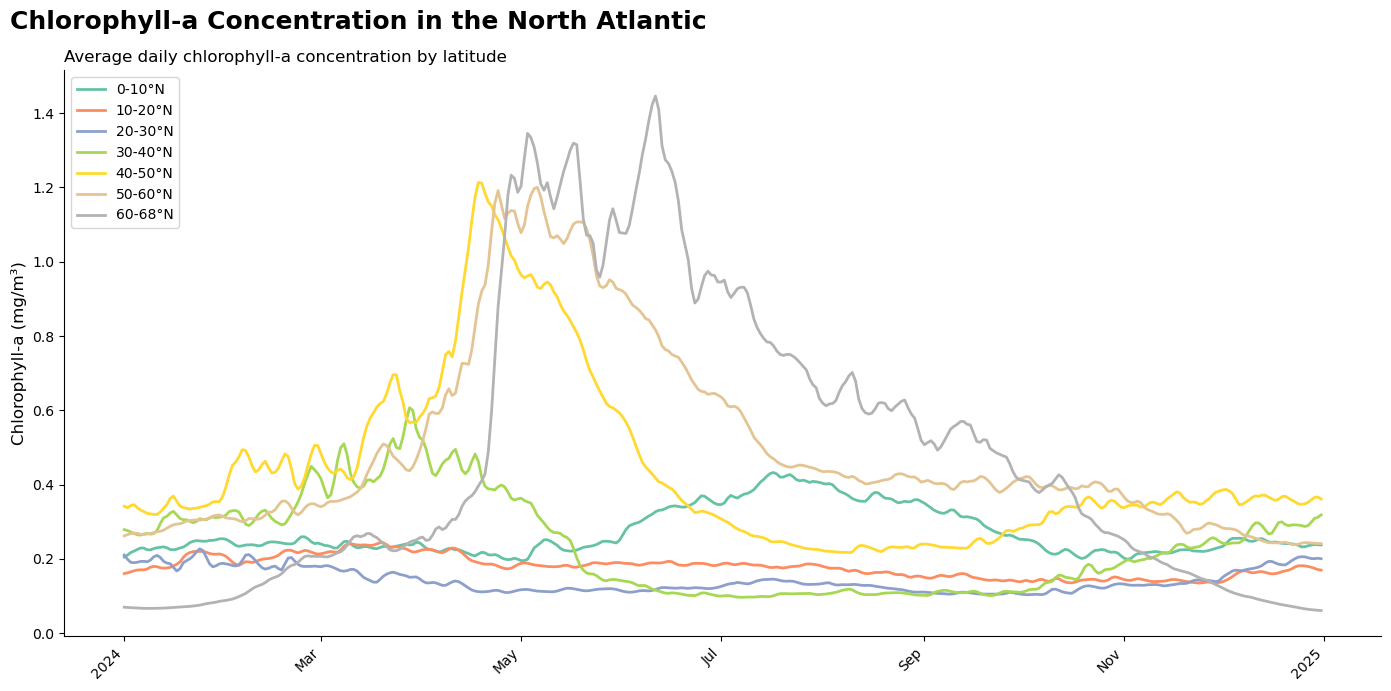

In [10]:
# Combine all dataframes from band_results
all_results = pd.concat(band_results)

# Create pivot table with time as index and lat_band as columns
pivot_data = all_results.pivot_table(index='time', columns='lat_band', values='chl')

# Sort by time to ensure smooth plotting
pivot_data = pivot_data.sort_index()

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(14, 7))  # Define figure size

# Set up a colormap with as many colors as there are latitude bands
cmap = plt.get_cmap("Set2", len(pivot_data.columns))

# Plot each latitude band
for i, col in enumerate(pivot_data.columns):
    ax.plot(
        pivot_data.index,
        pivot_data[col],
        label=col,  # Format is already "X-Y°N"
        color=cmap(i),
        linewidth=2
    )

# --- Titles and labels ---
plt.suptitle(
    "Chlorophyll-a Concentration in the North Atlantic",
    fontsize=18, fontweight="bold", x=0.01, ha='left'
)
plt.title(
    "Average daily chlorophyll-a concentration by latitude",
    fontsize=12, loc='left'
)

# --- X-axis: auto-formatting for any time range ---
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for readability

# Add y-axis label
ax.set_ylabel("Chlorophyll-a (mg/m³)", fontsize=12)

# --- Styling ---
ax.legend(title="", loc="upper left", fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## 🧭 **7. Next Steps**

After exploring the chlorophyll-a patterns by latitude, you may notice that chlorophyll-a concentrations below 30°N remained relatively stable throughout the year. To understand this a bit more, I consulted with an ocean scientist, Elodie Gutknecht at Mercator Ocean. She explained that the North Atlantic Spring Bloom generally occurs between **30° and 70°N**, and is defined by a **sharp spike in phytoplankton concentrations** over a short period of time.

With this in mind, we can now focus our map visualization on the **2024 Spring Bloom Season** of (March to June) and a **smaller geographic window** that captures the most relevant activity.

In the next notebook, we'll extract daily chlorophyll-a timesteps from our Zarr file and **export each one as a GeoTIFF**, allowing us to style and animate bloom dynamics in QGIS.

Continue to:  
👉 [`03_zarr_to_geotiffs.ipynb`](03_zarr_to_geotiffs.ipynb)
